In [1]:
import os
import sys
import fnmatch

import numpy as np

import GPy
import tables
import ml_gpr
import libpipe
import importlib



import emcee
import corner
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.interpolate

from ps_eor import datacube, pspec, psutil, simu, fitutil, fgfit

#import ml_gpr

import astropy.units as u
import astropy.constants as const
import astropy.stats as astats

PATH = '../codes' # CHANGE THAT
sys.path.insert(1,PATH)
import IAE_JAX_v2_devl_08_09_21 as iae
import ml_gpr as ml_gpr_IAE

mpl.rcParams['image.cmap'] = 'viridis'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

def normalize(X,opt=1):
    Y = X.T
    if opt == 1:
        Y = Y/np.sum(abs(Y),axis=0)
    if opt == 2:
        Y = Y/np.sqrt(np.sum(Y**2,axis=0))
    return Y.T

# Purpose of this notebook

- Load 21cmFast image cubes 
- produce power-spectra for each cube
- normalize the power-spectra
- train the IAE on this data set

# Define some common variables here

In [9]:
kbins = np.logspace(np.log10(0.05), np.log10(2.5), 13)
k_mean = np.array([0.05730528, 0.08320909, 0.11519442, 0.16067338, 0.22356231,
                   0.30937082, 0.42911561, 0.59454327, 0.82347184, 1.10628762,
                   1.54903247, 2.11011604])

# Generate power-spectra from the images cubes and save them locally for later use

If have your own simulations, otherwise jump to next section

In [10]:
# Define here some constants and the directory containing the simulation and power-spectra

ps_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/cov/simu_400mpc'
models_21cm_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/Programs/models'
models_21cm_dir = '/net/node128/data/users/lofareor/nenufar/21cmFast/simu_400mpc'
ps_21ssd_dir = '/net/node128/data/users/lofareor/nenufar/21SSD/'

n_pix = 200
box_size_cmpc = 400

zetas = np.arange(10, 250, 5)
tvirs = np.arange(4, 6, 0.1)
rmfps = np.arange(5, 25, 2)
print(len(zetas), len(tvirs), len(rmfps))
all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T

def get_ps(z, zeta, tvir, rmfp):
    return pspec.SphericalPowerSpectra.load_from_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')


def save_ps(ps3d, z, zeta, tvir, rmfp):
    ps3d.save_to_txt(f'{ps_dir}/ps_z{z}_zeta{zeta:.1f}_tvir{tvir:.1f}_rmfp{rmfp:.1f}.txt')


def get_vis_cube(z, zeta, tvir, rmfp):
    return datacube.CartDataCube.load(f'{models_21cm_dir}/box_z{z:.1f}_zeta{zeta:.2f}_tvir{tvir:.2f}_rmfp{rmfp:.2f}')

# Function to produce the power-spectra from the image cube. It should be run only once
def generate_all_ps(z):
    pr = psutil.progress_report(all_params.shape[0])

    for i, (zeta, tvir, rmfp) in enumerate(all_params):
        pr(i)
        i_cube = get_vis_cube(z, zeta, tvir, rmfp)
        ps_build = pspec.PowerSpectraBuilder()
        ps_gen = ps_build.get(i_cube, fmhz_range=[i_cube.freqs.min() * 1e-6, i_cube.freqs.max() * 1e-6],
                              du=10, umax=1000, umin=30, rmean_freqs=False, ps2d_pos_only=False, 
                              window_fct='hann')

        ps3d = ps_gen.get_ps3d(kbins, i_cube)
        save_ps(ps3d, z, zeta, tvir, rmfp)


def get_all_ps(z, step_parameters=1, shuffle=True):
    ps3d = get_ps(z, 100, 5, 13)

    zetas = np.arange(10, 250, step_parameters * 5)
    tvirs = np.arange(4, 6, step_parameters * 0.1)
    rmfps = np.arange(5, 25, step_parameters * 2)
    all_params = np.array(np.meshgrid(zetas, tvirs, rmfps)).reshape(3, -1).T

    # Load all 1D normalized covariance
    all_ps = np.array([get_ps(z, zeta, tvir, rmfp).data for zeta, tvir, rmfp in all_params])

    # shuffle the set
    np.random.shuffle(all_ps)

    # discard PS which are too low
    idx = all_ps.sum(axis=1) > 1e-4
    all_ps = all_ps[idx]
    all_params = all_params[idx]

    # normalize it so that it is flatter (multiply by k ** -1) and between 0 and 1
    all_ps = all_ps / (ps3d.k_mean ** -3 * all_ps).sum(axis=1)[:, None]
    all_ps = all_ps * ps3d.k_mean ** -1
    norm_factor = all_ps.max()
    all_ps = all_ps / norm_factor

    return all_ps, all_params, norm_factor

48 20 10


# Loading a selection of power-spectra for ML

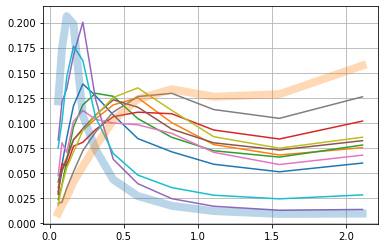

In [11]:
simu_all_ps_dir = 'simu/21cmFAST_3params_400mpc'

def get_all_ps_cache(z):
    all_ps = np.load(simu_all_ps_dir + f'/all_ps_21cmFast_z{z}_400Mpc.npy')
    all_params = np.load(simu_all_ps_dir + f'/all_params_21cmFast_z{z}_400Mpc.npy')

    return all_ps, all_params

def select_params(all_params, num):
    # Function to 
    n_f, n_p  = all_params.shape
    u_params = [np.unique(all_params[:, k]) for k in range(n_p)]
    n_u_p = np.array([len(k) for k in u_params])
    f = (n_f / num) ** (1 / 3)
    n_sel_u_p = np.clip(np.round(n_u_p / f), 2, n_f).astype(int)
    n_u_p, n_sel_u_p

    u_params_selected = [k[np.linspace(0, len(k) - 1, n).astype(int)] for k, n in zip(u_params, n_sel_u_p)]
    idx_all_params_selected = np.prod([np.in1d(all_params[:, i], k) for i, k in enumerate(u_params_selected)], axis=0)
    idx_all_params_selected = idx_all_params_selected.astype(bool)

    return idx_all_params_selected

def get_data(all_ps, all_params, n_train):
    idx_train = select_params(all_params, n_train)
    mask_train = np.zeros(all_ps.shape[0], dtype=bool)
    mask_train[idx_train] = 1

    return all_ps[mask_train], all_ps[~mask_train], all_params[mask_train], all_params[~mask_train]

z = 10.1
all_ps, all_params = get_all_ps_cache(z)

train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 500)

Xtrain = normalize(train_data)

AP = np.load("AP.npy")
AnchorPoints = normalize(AP)[[4,1,2,0,3,5],:]

plt.plot(k_mean, Xtrain[0:10,:].T)
plt.plot(k_mean, AnchorPoints[0:2,:].T,lw=8,alpha=0.3)

# IAE with different number of samples

In [6]:
## Here code to learn IAE models with different dimensionalities

def ApplyIAE(X_train,fname_in=None,name="test",batch_size=100,AnchorPoints=None,AP=None):
    
    NL = 3
    step_size = 0.01
    t = X_train.shape[1]
    NSize = t*np.ones((NL+1,),dtype='int')
    niter = 5000
    reg_parameter=1000
    noise_level = 0.01
    fname = "IAE_models/"+name
    
    if fname_in is not None:
        print("Use pre-run model")
        Model = iae.load_model("IAE_models/"+fname_in)
    else:
        Model = None
    
    # Old version

    if AP is None:
    
        learnfunc = iae.IAE(Model=Model,fname=fname,noise_level=noise_level, AnchorPoints=AnchorPoints,NSize=NSize,active_forward='mish',active_backward='sft', reg_parameter=reg_parameter,step_size=step_size)
        outref = learnfunc.learning_stage(X_train,XValidation=X_train, niter=niter,batch_size=batch_size)
        
    else:
    
        learnfunc = iae.IAE(Model=Model)
        outref = learnfunc.learning_stage_AP(X_train,XValidation=X_train, niter=niter,batch_size=batch_size,restart_freq=2000,fname=name)

    

In [ ]:
n_ss = [50,500,5000]
n_dim = [2,3,4,5,6]

train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 5000)
I = np.random.permutation(train_data.shape[0])
batch_size = 50
AP = np.load("AP.npy")

for latent_dim in n_dim:
    fname_in = None
    #fname_in=f'iae_21cmFAST_3params_v2_AP_{latent_dim}_z{z}_n{500}' #we should remove that later
    for n_s in n_ss:
        
        #Xtrain = train_data.T
        #
        
        Xtrain = train_data[I[0:n_s]].T
        Xtrain = Xtrain/np.sum(Xtrain,axis=0)
        Xtrain = Xtrain.T
        
        AP = np.load("AP.npy")
        Q = AP[[4,1,2,0,3,5],:].T
        AnchorPoints = Q[:,0:latent_dim]
        AnchorPoints = AnchorPoints/np.sum(AnchorPoints,axis=0)
        AnchorPoints =AnchorPoints.T
        name=f'080921_iae_21cmFAST_3params_v2_AP_{latent_dim}_z{z}_n{n_s}'
        ApplyIAE(Xtrain,fname_in=fname_in,name=name,batch_size=batch_size,AnchorPoints=AnchorPoints)
        fname_in = name
        name=f'080921_iae_21cmFAST_3params_v2_AP_{latent_dim}_z{z}_n{n_s}_Updated'
        ApplyIAE(Xtrain,fname_in=fname_in,name=name,batch_size=batch_size,AnchorPoints=AnchorPoints,AP=True)
        #fname_in = name
        

In [ ]:
# Check the results
n_ss = [50,500, 5000]
n_dim = [2,3,4,5,6]


ratio2=[]
train_data, test_data, train_params, test_params = get_data(all_ps, all_params, 5000)
test = train_data.T
test = test/np.sum(test,axis=0)
test = test.T

for latent_dim in n_dim:
    for n_s in n_ss:
        fname='IAE_models/'+f'080921_iae_21cmFAST_3params_v2_AP_{latent_dim}_z{z}_n{n_s}_Updated'
        Model = iae.load_model(fname)
        Model["step_size"]=1e-3
        learnfunc = iae.IAE(Model=Model)
        out = learnfunc.barycentric_span_projection(test,niter=5000)
        nMSE = -20*np.log10(np.linalg.norm(out["XRec"]-test,axis=1)/np.linalg.norm(test,axis=1))
        ratio2.append((out["XRec"]/test).flatten()-1)
        plt.figure()
        plt.hist(nMSE,bins=100)
        plt.title(f'MSE: {np.mean(nMSE)}, latent_dim: {latent_dim}, n_s: {n_s}')
       